In [1]:
import sys
import os
sys.path.insert(0, '../icenumerics')
import icenumerics as ice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm.notebook as tqdm

ureg = ice.ureg

from importlib import reload  
import From_Cairo_to_Shakti as lattices
reload(lattices)

from icenumerics.geometry import ordering 


%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

# Simulation From Cairo lattice to Shakti lattice

Here, we will generate all the functions needed to run the code and place them in the From_Cairo_to_Shakti.py file. This is a previous step for having a script with parallel simulations.

In [3]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-13.1"

Defining the elementary parameters to generate the lattice

In [4]:
d = 13 # Interparticle distance
trap_sep_l = 10 # trap_sep parameter of the edge connecting 3 coordination and 4 coordination vertices
s_l4 = d*np.sqrt(2)/2
theta = 21*np.pi/180

In [5]:
trap_sep_a, s_l3, a, l, plaquette_cte = lattices.lattice_parameters(theta, d, trap_sep_l, s_l4)

In [6]:
sp = lattices.spins()
ureg = ice.ureg
Sx = 4
Sy = 4
sp.create_lattice(geometry = "from_cairo_to_shakti", size =[Sx,Sy], theta = theta,d = d ,trap_sep_l = trap_sep_l ,s_l4 = s_l4, plaquette_cte = plaquette_cte*ureg.um, border="periodic")
sp.order_spins(ordering.random_ordering)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/From_Cairo_to_Shakti.py:227: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


(-23.486661704980254,
 377.41952770028263,
 -74.04849970430917,
 326.8576897009537)

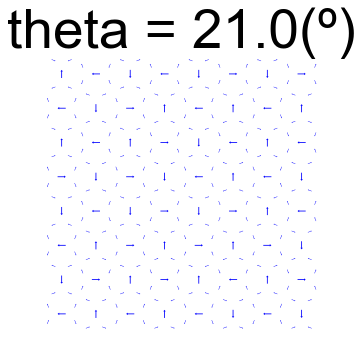

In [7]:
f, (ax1) = plt.subplots(1,1,figsize = (5,5))

angle = np.round(theta*180/np.pi,0)
b = str(angle)
sp.display(ax1)
plt.title('theta = '+ b+'(º)', size = 55 )
plt.axis('off')
#plt.savefig(a+'.png')

In [8]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_long = ice.trap(trap_sep = trap_sep_l*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_short = ice.trap(trap_sep = trap_sep_a*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

traps = []

In [9]:
for s in sp:
    
    if ( s.direction[0].magnitude == 2*trap_sep_l or s.direction[0].magnitude == -2*trap_sep_l or 
        s.direction[1].magnitude == 2*trap_sep_l or s.direction[1].magnitude == -2*trap_sep_l ):
        
        traps.append(trap_short)
        
    else:
        
        traps.append(trap_long)

In [10]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)

col.pad_region(20*ureg.um) 

In [11]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)
#   boundaries = ["p", "p", "p"])

In [12]:
change_m_time = 2000*ureg.s
total_time = 10*ureg.s
col.simulate(world,
             name = "shakti_10x10_25mT-TEST",
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

scanning file


In [13]:
col.sim.field.fieldz = "(time<2000000000)*v_Bmag*time/%f+(time>=2000000000)*v_Bmag"%(change_m_time.to(ureg.us).magnitude)
col.run_simulation()

In [14]:
four_coord, three_coord = lattices.from_Cairo_to_Shakti_vertices(Sx,Sy, theta, a, l, plaquette_cte)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/From_Cairo_to_Shakti.py:139: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_four_coord[:,1] = four_coordY
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/From_Cairo_to_Shakti.py:171: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_three_coord[:,1] = three_coordY


In [15]:
vertices_pos = np.append(four_coord,three_coord, axis = 0)

In [16]:
def extracting_trap_positions(col):
    trap_pos = []

    for c in col:

        trap_pos.append(c.center.magnitude)

    trap_pos = np.array(trap_pos)
    
    return trap_pos

In [17]:
trap_pos = lattices.extracting_trap_positions(col)

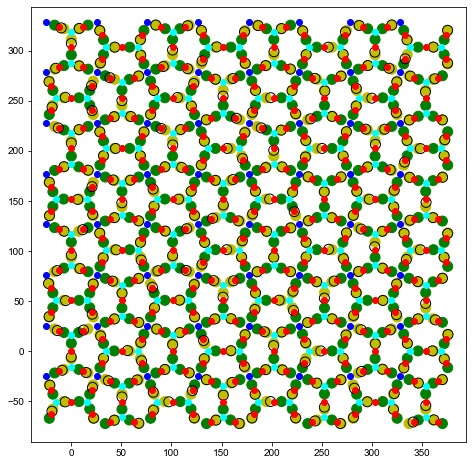

In [18]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

plt.plot(four_coord[:,0],four_coord[:,1],'o', color = 'blue')
plt.plot(three_coord[:,0],three_coord[:,1],'o', color = 'cyan')
plt.plot(trap_pos[:,0],trap_pos[:,1],'o', color = 'red')


col.display(ax1)

In [19]:
def infer_edges(vertices_pos,trap_pos):
    
    tree = spa.KDTree(vertices_pos)
    dist, edges = tree.query(trap_pos, k = 2)
    data_edges = {'start': edges[:,0], 'stop': edges[:,1]}
    df = pd.DataFrame(data=data_edges)
    return df

In [20]:
df = lattices.infer_edges(vertices_pos,trap_pos)
df

,start,stop
0,64,65
1,64,0
2,64,1
3,65,2
4,65,3
...,...,...
315,190,191
316,190,63
317,190,187
318,191,45


In [21]:
len(vertices_pos)

192

In [22]:
v_non_inferred = ice.vertices(
    positions = vertices_pos,
    edges = df[["start","stop"]].values)

In [23]:
col.set_state_from_frame(-1)

In [24]:
v_non_inferred.update_directions(col)

In [25]:
v_non_inferred.classify_vertices(ice.ice_to_spins(col))

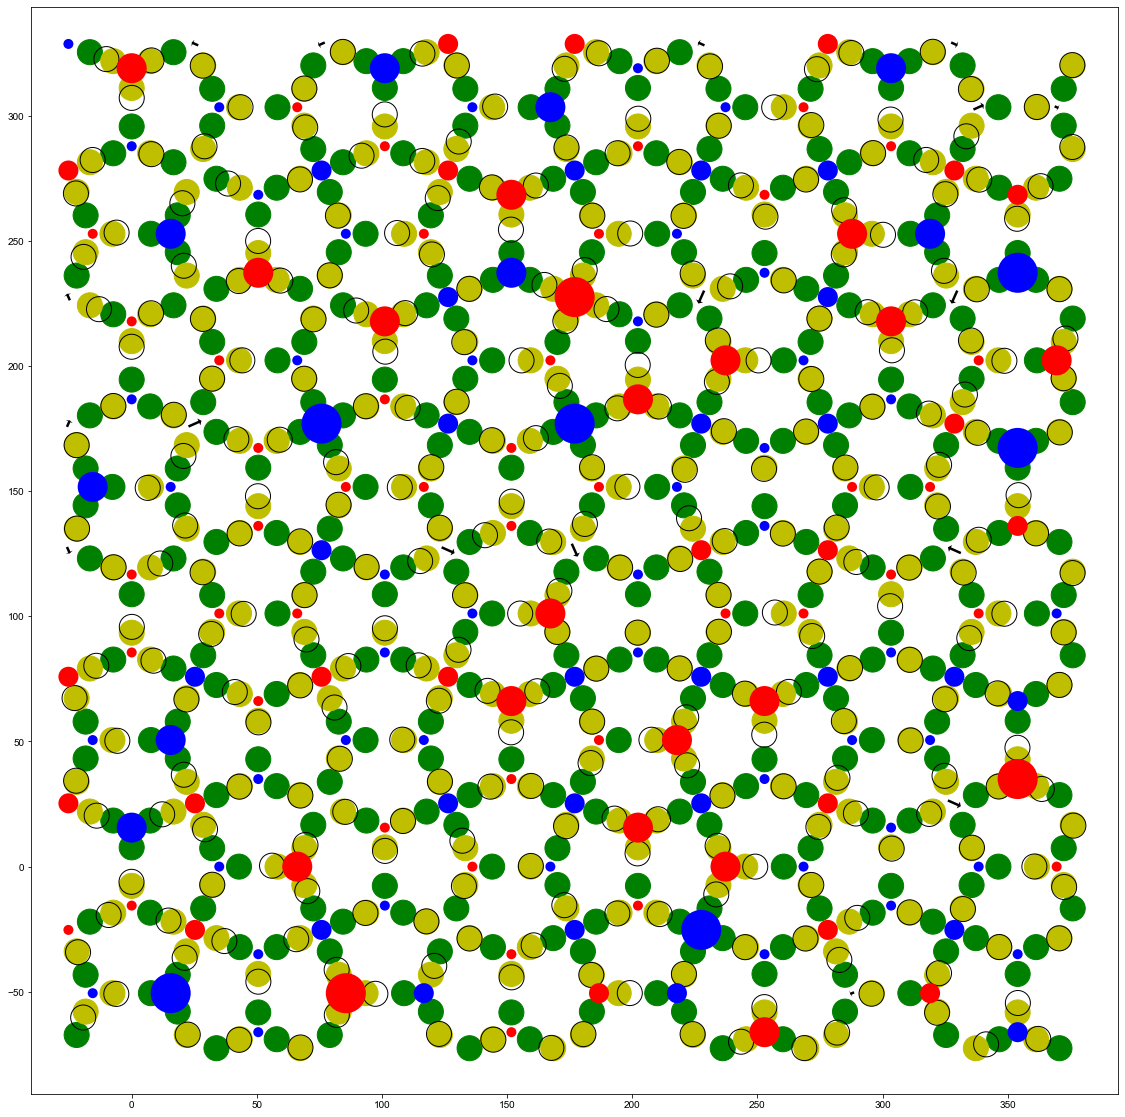

In [26]:
f, (ax1) = plt.subplots(1,1,figsize = (20,20))

col.display(ax1)
v_non_inferred.display(ax1)

In [27]:
v_non_inferred.vertices.groupby('charge').count()

,x,y,coordination,dx,dy
charge,,,,,
-4,6,6,6,6,6
-3,9,9,9,9,9
-2,25,25,25,25,25
-1,46,46,46,46,46
0,23,23,23,23,23
1,42,42,42,42,42
2,21,21,21,21,21
3,17,17,17,17,17
4,3,3,3,3,3


In [28]:
frames = col.trj.index.get_level_values("frame").unique()

v_df = []

for f in tqdm.tqdm(frames[::1]):
    col.set_state_from_frame(f)

    v_non_inferred.update_directions(col)
    v_non_inferred.classify_vertices(ice.ice_to_spins(col))
    vertices = v_non_inferred.vertices

    v_df.append(vertices.copy())


v_df = pd.concat(v_df,keys=frames[::1], names = ["frame"])

In [29]:
v_df.loc[9].groupby('charge').count()

,x,y,coordination,dx,dy
charge,,,,,
-4,6,6,6,6,6
-3,9,9,9,9,9
-2,25,25,25,25,25
-1,46,46,46,46,46
0,23,23,23,23,23
1,42,42,42,42,42
2,21,21,21,21,21
3,17,17,17,17,17
4,3,3,3,3,3
